In [73]:
from __future__ import print_function

import argparse

import numpy as np
import torch
import torch.utils.data
import torch.nn.functional as F
import sys
sys.path.append('../model')
from model import RecurrentNetTimeFixed

import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
# when_slow_signal = [0, 7,14]
slow_signal_values = [1.278, 2.176, 0.451]
def lsm_signals(n_episodes=100, n_in=100, stim_dur=15,
                sig1_stim_dur=20, resp_dur=10, each_episodes=10, kappa=5.0, spon_rate=0.2, n_stim=3):
    phi = np.linspace(0, np.pi, n_in)
    n_loc = 1
    nneuron = n_in * n_loc
    total_dur = n_stim * (stim_dur + resp_dur)
    G = (1.0 / stim_dur) * np.random.choice([1.0], 1)
    G = np.repeat(G, n_in, axis=0).T
    G = np.tile(G, (stim_dur, 1))

    # signal2
    Stims = []
    Stims_ = []
    Ls = []
    Rs = []
    for episode in range(n_episodes):
        episode_stim = []
        for i in range(n_stim):
            S = np.pi * np.random.rand(1)
            S_ = S.copy()
            S = np.repeat(S, n_in, axis=0).T
            S = np.tile(S, (stim_dur, 1))
            Stims.append(S)
            episode_stim.append(S_)

            # Noisy responses
            L = G * np.exp(kappa * (np.cos(
                2.0 * (S - np.tile(phi, (stim_dur, n_loc)))) - 1.0))  # stim

            Ls.append(L)
            R = np.random.poisson(L)
            Rs.append(R)
        Stims_.append(episode_stim)
        Lr = (spon_rate / resp_dur) * np.ones((resp_dur * n_stim, nneuron))  # resp
        Rr = np.random.poisson(Lr)

        Rs.append(Rr)

    signal2 = np.concatenate(tuple(Rs), axis=0)

    G1 = (3.0 / sig1_stim_dur) * np.random.choice([1.0], 1)
    G1 = np.repeat(G1, n_in, axis=0).T
    G1 = np.tile(G1, (sig1_stim_dur, 1))
    # signal1 & target
    a = np.random.poisson(0.8, n_episodes)
    Rs1 = []
    accum_signal = np.pi * np.random.rand(1)
    target_list = []

    for episode in range(n_episodes):
        target_list.append(np.zeros(stim_dur * n_stim))
        if a[episode] == 2 or episode % each_episodes == 0:
            # print(episode)
            accum_signal = np.pi * np.random.rand(1)
            # accum_signal = slow_signal_values[episode//each_episodes]
            S = np.repeat(accum_signal, n_in, axis=0).T
            S = np.tile(S, (sig1_stim_dur, 1))

            L = G1 * np.exp(kappa * (np.cos(
                2.0 * (S - np.tile(phi, (sig1_stim_dur, n_loc)))) - 1.0))  # stim
            R = np.random.poisson(L)
            Rs1.append(R)
        else:
            Lr = (spon_rate / resp_dur) * np.ones((sig1_stim_dur, nneuron))  # resp
            R = np.random.poisson(Lr)
            Rs1.append(R)
        L_spont = (spon_rate / resp_dur) * np.ones((total_dur - sig1_stim_dur, nneuron))  # resp
        R = np.random.poisson(L_spont)
        Rs1.append(R)

        for i in range(n_stim):
            target = np.repeat(Stims_[episode][i]+accum_signal, resp_dur, axis=0)
            # target = np.repeat(Stims_[episode][i], resp_dur, axis=0)
            target_list.append(target)

    signal1 = np.concatenate(tuple(Rs1), axis=0)

    target = np.concatenate(tuple(target_list), axis=0)
    target = np.expand_dims(target, 1)

    signal = np.concatenate((signal1, signal2), axis=1)
    return signal, target, Stims_

In [109]:
signal, target, stims_ = lsm_signals(n_episodes=21,
                                 stim_dur=7,
                                 sig1_stim_dur=7,
                                 resp_dur=5,
                                 each_episodes=7,
                                 spon_rate=0.1)

In [110]:
signal.shape

(756, 200)

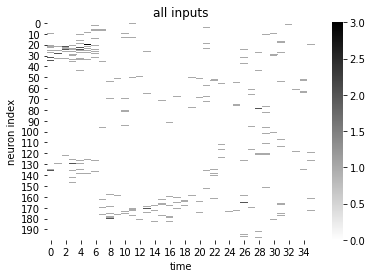

In [111]:
import seaborn as sns
from datetime import datetime
import pytz
sns.heatmap(signal[:36].T, cmap='gray_r')
plt.xlabel('time')
plt.ylabel('neuron index')
plt.title('all inputs')
time_stamp = datetime.strftime(datetime.now(pytz.timezone('Japan')), '%m%d%H%M')
plt.savefig('./images_for_seminar/{}_input_sample2.png'.format(time_stamp), dpi=100)

In [32]:
input_sample = [2.21487726]*7+[1.04392901]*7+[0.70196071]*7

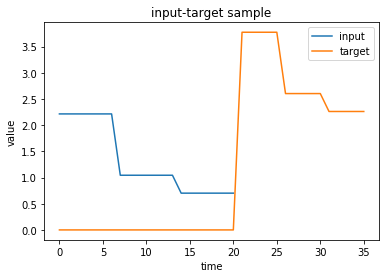

In [33]:
plt.plot(input_sample, label='input')
plt.plot(target.T[0][324:360], label='target')
# plt.plot(output[0].data.numpy().T[0][324:360], label='output')
plt.xlabel('time')
plt.ylabel('value')
plt.title('input-target sample')
plt.legend()
time_stamp = datetime.strftime(datetime.now(pytz.timezone('Japan')), '%m%d%H%M')
plt.savefig('./images_for_seminar/{}_input_target_sample.png'.format(time_stamp), dpi=200)

In [102]:
G = (1.0 / 7) * np.random.choice([1.0], 1)
G = np.repeat(G, 100, axis=0).T
G = np.tile(G, (7, 1))

# S1 = np.pi * np.random.rand(1)
S1 = 2
S = 2  # S: signal
S1 = np.repeat(S1, 100, axis=0).T
S1 = np.tile(S1, (7, 1))
# print(S1.shape)

# Noisy responses
L1 = G * np.exp(5.0 * (np.cos(
            2.0 * (S1 - np.tile(np.linspace(0, np.pi, 100), (7, 1)))) - 1.0))  # stim



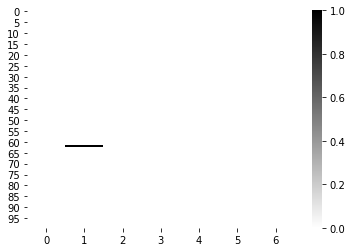

In [104]:
sns.heatmap(R2.T, cmap='gray_r')


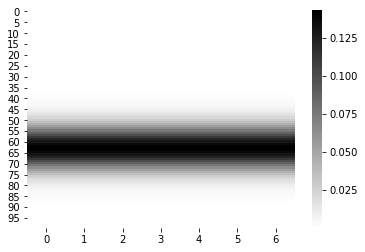

In [71]:
sns.heatmap(L1.T, cmap='gray_r')
plt.savefig('example1.png', dpi=100)

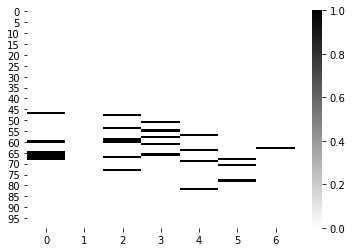

In [72]:
sns.heatmap(R1.T, cmap='gray_r')
plt.savefig('example2.png', dpi=100)